In [1]:
import numpy as np
import pandas as pd
import math
from concurrent.futures import ThreadPoolExecutor
from sympy import symbols
from sympy.solvers.solveset import nonlinsolve
import time
import logging

number_of_sim = 180
number_of_drive = 1
numberofsmallelements = 2000

# 定义常数和材料属性
E = 169e9
rho = 2330
t = 25e-6
eps_0 = 8.85e-12
beta = 4.730041

alpha_n = (np.sin(beta) - np.sinh(beta)) / (np.cosh(beta) - np.cos(beta))
pi_160 =(160 / 180) * math.pi
pi_10 = (10 / 180) * math.pi
phi = np.linspace(pi_10, pi_10+pi_160, number_of_sim)

# 定义变量范围
#w_t_values = np.arange(5e-6, 20e-6, 1e-6) #16
#l_t_values = np.arange(100e-6, 1000e-6, 50e-6) #19
Q_values = np.arange(5000, 50000 , 2500) # 19
#V_values = np.arange(1, 10, 1) # 10
#d_values = np.arange(2e-6, 10e-6, 1e-6) #9
# electrode_length_values = np.arange(100e-6, 900e-6 , 10e-6) #81
# electrode_width_values = np.arange(5e-6, 30e-6, 1e-6) #26
# w_c_values = np.arange(5e-6, 20e-6, 0.2e-6) #76 
# l_c_values = np.arange(5e-6, 30e-6 , 1e-6) #26

### 视为常数
electrode_length = 700e-6
electrode_width = 20e-6
w_c= 10e-6
l_c = 20e-6
d_values  = 6e-6
V_values = 5
w_t_values = 10e-6
l_t_values= 500e-6

#参与循环
w_t = w_t_values
l_t= l_t_values


#预计算 w_t,l_t 相关参数

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
from scipy.optimize import fsolve
import math
import scipy.io as spio
from sympy.core.symbol import symbols
from sympy.solvers.solveset import nonlinsolve
import pandas as pd

#结果数组
results = []
numberofsmallelements = 2000
length_x = np.zeros(numberofsmallelements)
modeshape_unnormalized = np.zeros(numberofsmallelements)
second_derivative = np.zeros(numberofsmallelements)
first_derivative = np.zeros(numberofsmallelements)

hasresult = 0
Noresult = 0


length_x = np.linspace(0, l_t- l_t/2000, 2000)
modeshape_unnormalized = -(-np.sin(beta * length_x / l_t) + np.sinh(beta * length_x / l_t) +
                        alpha_n * (-np.cos(beta * length_x / l_t) + np.cosh(beta * length_x / l_t)))
second_derivative = -1 / np.max(modeshape_unnormalized) * (beta ** 2) * (np.sin(beta * length_x / l_t) + np.sinh(beta * length_x / l_t) + alpha_n * (np.cos(beta * length_x / l_t) + np.cosh(beta * length_x / l_t)))
first_derivative = -1 / np.max(modeshape_unnormalized) * beta * (-np.cos(beta * length_x / l_t) + np.sinh(beta * length_x / l_t) + alpha_n * (np.sin(beta * length_x / l_t) + np.cosh(beta * length_x / l_t)))

modeshape1 = modeshape_unnormalized / np.max(modeshape_unnormalized)

dx = length_x[1] - length_x[0]
print (dx)
m_coef_b = np.sum(modeshape1 ** 2 * dx / l_t)
print(m_coef_b)
k_coef_b = np.sum(second_derivative ** 2 * dx / l_t)
print(k_coef_b)
k_coef_b3 = np.sum(first_derivative ** 2 * dx / l_t)
print(k_coef_b3)

k_tt = k_coef_b / 12 * E * t * ((w_t / l_t) ** 3)
k_t3 = k_coef_b3 * E * t * w_t / (l_t ** 3)
k_t = k_tt
Mass = rho * (t * w_t * l_t * m_coef_b + electrode_length * electrode_width * t + w_c * l_c * t *2)
omega_0 = math.sqrt(k_t / Mass)
freq_0 = omega_0 / (2 * math.pi)

print("预计算完成,Omega = ",omega_0)
print("有结果:", hasresult, "无结果:", Noresult)

2.5e-07
0.3964778987745917
198.46291694197498
12.564313913982787
预计算完成,Omega =  765368.9223161091
有结果: 0 无结果: 0


# 计算循环

In [11]:

V = V_values
d = d_values
eps_0 = 8.85e-12
trans_factor = eps_0 * V * electrode_length * t  / (d ** 2)
k_e = 2 * trans_factor * V / d
k_e3 = 4 * trans_factor * V / (d ** 3)      



for Q in Q_values:
    c = math.sqrt(Mass * k_t) / Q
# 
    number_of_drive = 5
    number_of_sim = 180
    
    freq = np.zeros((number_of_sim, number_of_drive))
    m_c = np.zeros((number_of_sim, number_of_drive)) ## motional current
    label_fig = ["" for x in range(number_of_drive)]
    
    for ii in range(number_of_drive):
        vac = 5e-3 + 0.1e-3 * ii        
        force_ac = vac * trans_factor
        vac_round = np.round(vac / 1e-3 , 2)
        label_fig[ii] = "vac = {} mV".format(vac_round)

        for i in range(number_of_sim):
            x, y = symbols('x, y', reals=True)
            try:
                solutions =  nonlinsolve([-Mass * (x ** 2) * y + (k_t - k_e) * y + (k_t3 - k_e3) * (y ** 3) * 3 / 4 - force_ac * math.cos(phi[i]), 
                                    c * x * y - force_ac * math.sin(phi[i])], 
                                    [x, y])
                for j in range(len(solutions)):
                    sol = solutions.args[j]
                    if np.abs(sol[0]) > omega_0 / 2 and np.abs(sol[0]) < omega_0 * 3 / 2 and sol[0] > 0:
                        freq[i, ii] = sol[0] / (2 * math.pi)
                        m_c[i, ii] = sol[1] * freq[i, ii] * 2 * math.pi * trans_factor / 1e-9 
                    else:
                        pass    
            except:
                pass
    if not np.all(freq == 0) or not np.all(m_c == 0):
        hasresult += 1
        print('has result:', hasresult)
        results.append(
            {
                'w_t': w_t,
                'l_t': l_t,
                'electrode_length': electrode_length,
                'electrode_width': electrode_width,
                'w_c': w_c,
                'l_c': l_c,
                'Q': Q,
                'V': V,
                'd': d,
                'Vac_ground': vac,
                'freq': freq[:, 0],
                'm_c': m_c[:, 0]
            }
        )
    else :
        Noresult += 1
        print('No result:', Noresult)
                                        
                        
results_df = pd.DataFrame(results, columns=['w_t', 'l_t', 'electrode_length', 'electrode_width', 'w_c', 'l_c', 'Q', 'V', 'd', 'Vac_ground' ,'freq', 'm_c'])
results_df.to_hdf(path_or_buf='Q_value.h5', key='mydata', mode='w')

                            

has result: 1
has result: 2
has result: 3
has result: 4
has result: 5
has result: 6
has result: 7
has result: 8
has result: 9
has result: 10
has result: 11
has result: 12
has result: 13
has result: 14
has result: 15
has result: 16
has result: 17
has result: 18


/var/folders/n7/v600f1k91rjfkqj_812w6ts40000gn/T/ipykernel_21342/2747968629.py:63: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['freq', 'm_c'], dtype='object')]

  results_df.to_hdf(path_or_buf='Q_value.h5', key='mydata', mode='w')


In [12]:
import h5py

# HDF5文件路径
file_path = 'Q_value.h5'

# 使用pandas读取HDF5文件中的DataFrame
results_df = pd.read_hdf(file_path, 'mydata')

print(results_df)

freq[:,0] =results_df['freq'][0]
m_c[:,0] =results_df['m_c'][0]


        w_t     l_t  electrode_length  electrode_width      w_c      l_c  \
0   0.00001  0.0005            0.0007          0.00002  0.00001  0.00002   
1   0.00001  0.0005            0.0007          0.00002  0.00001  0.00002   
2   0.00001  0.0005            0.0007          0.00002  0.00001  0.00002   
3   0.00001  0.0005            0.0007          0.00002  0.00001  0.00002   
4   0.00001  0.0005            0.0007          0.00002  0.00001  0.00002   
5   0.00001  0.0005            0.0007          0.00002  0.00001  0.00002   
6   0.00001  0.0005            0.0007          0.00002  0.00001  0.00002   
7   0.00001  0.0005            0.0007          0.00002  0.00001  0.00002   
8   0.00001  0.0005            0.0007          0.00002  0.00001  0.00002   
9   0.00001  0.0005            0.0007          0.00002  0.00001  0.00002   
10  0.00001  0.0005            0.0007          0.00002  0.00001  0.00002   
11  0.00001  0.0005            0.0007          0.00002  0.00001  0.00002   
12  0.00001 

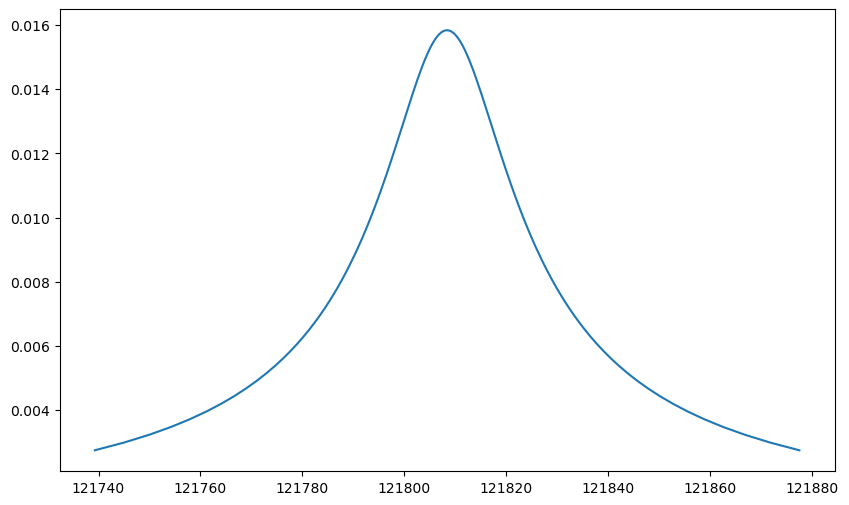

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(freq[:,0],m_c[:,0], label=label_fig[0])
plt.show()